In [2]:
### uses vgg.json file to create binary images of the ground truth fretboard segmentations

import cv2 as cv
import json
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image

# expects fretboard dataset to be in data folder on same level as tabs_generator folder
train_str = "test" # change to train or test to perform on respective data
dataset_path = "../data/fretboard_dataset/"
images_path = f"../data/fretboard_dataset/fretboard_frames_{train_str}/"
image_fns = os.listdir(images_path)
json_fn = os.path.join(dataset_path, f"fretboard_labels_{train_str}_vgg.json")
f = open(json_fn)
data = json.load(f) # data is dict of json contents
k = list(data.keys())

for i, fn in enumerate(image_fns):
    img_path = os.path.join(images_path, fn)
    out_path = os.path.join(images_path, "annotated_"+fn)
    img = np.asarray(Image.open(img_path)) # loads images w/ range of 0:255
    x_list = data[k[i]]["regions"]["0"]["shape_attributes"]["all_points_x"] # list of rectangle coordinates
    y_list = data[k[i]]["regions"]["0"]["shape_attributes"]["all_points_y"]
    x_list.pop(-1) # remove duplicate of first coordinate from end of lists
    y_list.pop(-1)
    poly_corners = np.asarray([list(zip(x_list, y_list))], dtype=np.int32) # repackage into np array w/ correct dtype
    new_img = np.zeros((img.shape[0], img.shape[1]), np.uint8) # create empty binary image mask
    new_img = cv.fillPoly(new_img, poly_corners, 255) # fill polygon of rectangle coordinates
    Image.fromarray(new_img).save(out_path) # save output image

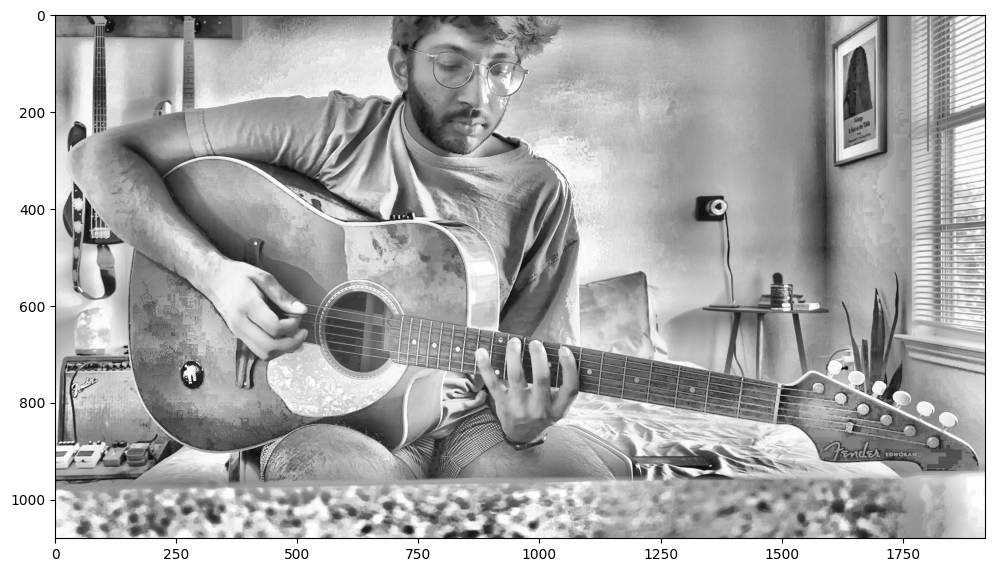

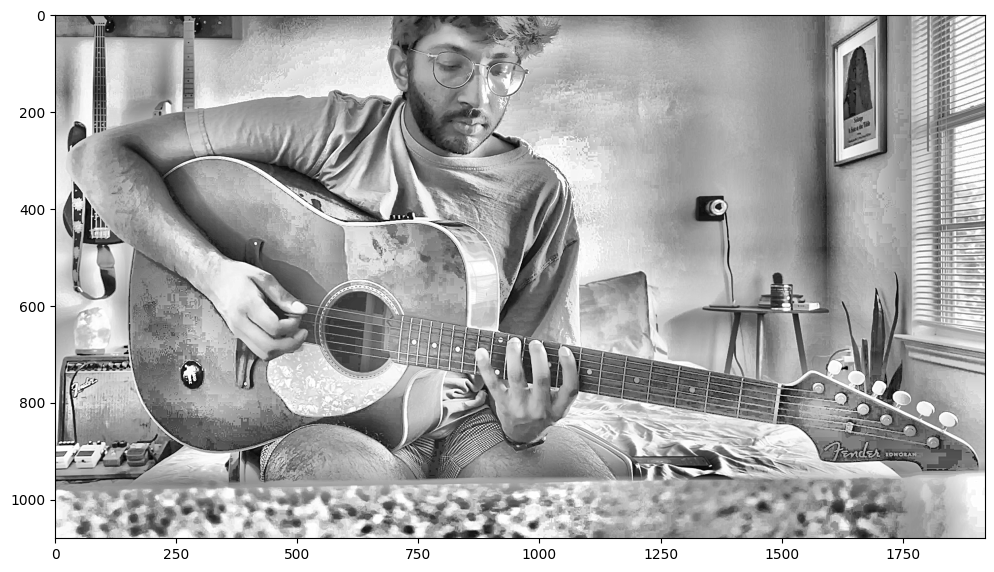

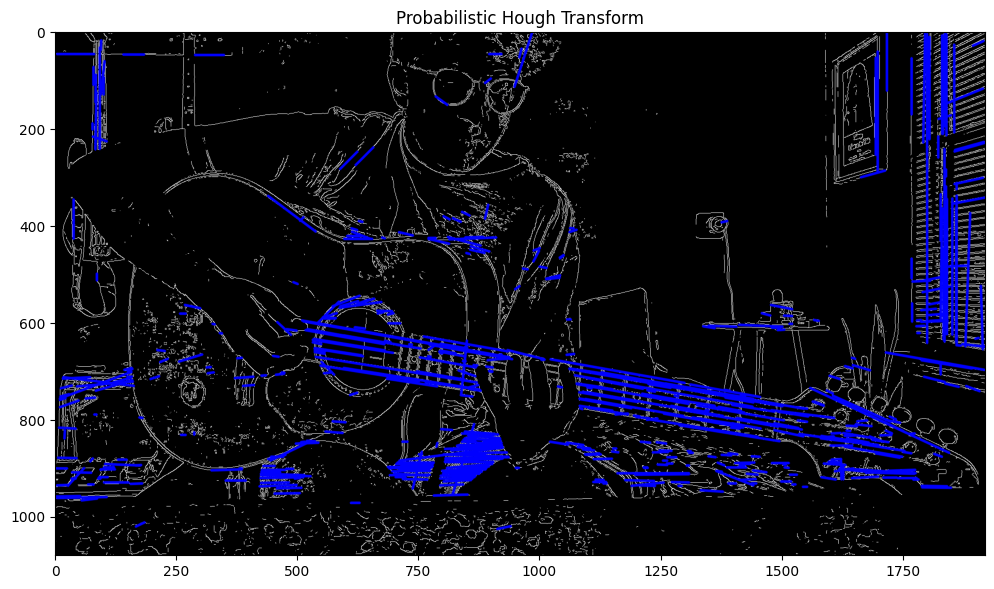

In [42]:
# generate hough lines of image
%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy.ndimage import median_filter

train_flag = True
dataset_path = "../data/fretboard_dataset/"
garrett_path = "../data/new_dataset/garrett_amogus/"
if train_flag:
    frames_path = "../data/fretboard_dataset/fretboard_frames_train/"
    out = "../data/fretboard_dataset/train.json"
else:
    frames_path = "../data/fretboard_dataset/fretboard_frames_test/"
    out = "../data/fretboard_dataset/test.json"

data = {}
frames_fn_list = os.listdir(frames_path)
train_fns = []
for f in frames_fn_list:
    if "annotated" not in f:
        train_fns.append(f)

num = 500 # top number of lines to keep
normalize = np.array([1920, 1080])
normalize = np.tile(normalize, num*2)

for frame_fn in train_fns[50:51]:
    img = cv.imread(os.path.join(frames_path, frame_fn))

    lab= cv.cvtColor(img, cv.COLOR_BGR2LAB)
    l_channel, a, b = cv.split(lab)
    # Applying CLAHE to L-channel
    clahe = cv.createCLAHE(clipLimit=50.0, tileGridSize=(10,10))
    cl = clahe.apply(l_channel)
    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv.merge((cl,a,b))
    # Converting image from LAB Color model to BGR color spcae
    img = cv.cvtColor(limg, cv.COLOR_LAB2BGR)

    gray = np.uint8(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    gamma = 0.6
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256): # gamma correction for contrast enhancement
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
        grayCE = cv.LUT(gray, lookUpTable)

    blurred = cv.GaussianBlur(grayCE, (0,0), 2.0)
    unsharp = cv.addWeighted(grayCE, 1.5, blurred, -.5, 0) # unsharp masking

    plt.figure(figsize=(12,12))
    plt.imshow(grayCE.astype(np.uint8), cmap="gray")
    plt.show()
    plt.figure(figsize=(12,12))
    plt.imshow(unsharp.astype(np.uint8), cmap="gray")
    plt.show()

    canny = cv.Canny(unsharp.astype(np.uint8), 200, 220, apertureSize=3, L2gradient=True) # canny edge detection

    cdstP = cv.cvtColor(canny, cv.COLOR_GRAY2RGB)
    linesP = cv.HoughLinesP(canny, 1, np.pi / 180, 50, None, 6, 10) # probabilistic Hough transform
    linesP = linesP[:num,:,:] # get top N lines

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

    
    linesP = linesP.ravel() / normalize
    linesP = linesP.tolist() # convert to coordinates
    data[frame_fn] = linesP

# with open(out, "w") as outfile:
#     json.dump(data, outfile)
# print("data written to " + out)

plt.figure(figsize=(12,12))
plt.imshow(cdstP, cmap="gray")
plt.title("Probabilistic Hough Transform")
plt.show()


In [97]:
# generate points from canny image
%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from random import sample

train_flag = False
dataset_path = "../data/fretboard_dataset/"
garrett_path = "../data/new_dataset/garrett_amogus/"
if train_flag:
    frames_path = "../data/fretboard_dataset/fretboard_frames_train/"
    out = "../data/fretboard_dataset/train.json"
else:
    frames_path = "../data/fretboard_dataset/fretboard_frames_test/"
    out = "../data/fretboard_dataset/test.json"

data = {}
frames_fn_list = os.listdir(frames_path)
train_fns = []
for f in frames_fn_list:
    if "annotated" not in f:
        train_fns.append(f)

num = 1000 # top number of points to keep

for frame_fn in train_fns:
    img = cv.imread(os.path.join(frames_path, frame_fn))

    lab= cv.cvtColor(img, cv.COLOR_BGR2LAB)
    l_channel, a, b = cv.split(lab)
    # Applying CLAHE to L-channel
    clahe = cv.createCLAHE(clipLimit=10.0, tileGridSize=(5,5))
    cl = clahe.apply(l_channel)
    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv.merge((cl,a,b))
    # Converting image from LAB Color model to BGR color spcae
    img = cv.cvtColor(limg, cv.COLOR_LAB2BGR)

    gray = np.uint8(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    gamma = 0.6
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256): # gamma correction for contrast enhancement
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
        grayCE = cv.LUT(gray, lookUpTable)

    blurred = cv.GaussianBlur(grayCE, (0,0), 2.0)
    unsharp = cv.addWeighted(grayCE, 1.25, blurred, -.25, 0) # unsharp masking

    # plt.figure(figsize=(12,12))
    # plt.imshow(unsharp.astype(np.uint8), cmap="gray")
    # plt.show()

    canny = cv.Canny(unsharp.astype(np.uint8), 200, 220, apertureSize=3, L2gradient=True) # canny edge detection

    nz = canny.nonzero()
    nz = list(zip(nz[0], nz[1]))
    samps = sample(nz, num)

    canny_sampled = np.copy(canny)
    canny_sampled[canny_sampled>0] = 0
    coords = []
    for s in samps:
        canny_sampled[s] = 255
        r = s[0] / img.shape[1]
        c = s[1] / img.shape[2]
        coords.append(c)
        coords.append(r)

    # plt.figure(figsize=(12,12))
    # plt.imshow(canny, cmap="gray")
    # plt.show()
    # plt.figure(figsize=(12,12))
    # plt.imshow(canny_sampled.astype(np.uint8), cmap="gray")
    # plt.show()


    data[frame_fn] = coords

with open(out, "w") as outfile:
    json.dump(data, outfile)
print("data written to " + out)



data written to ../data/fretboard_dataset/test.json


Idea for finding the fretboard:
1. create ideal locations of the fretboard markers
2. detect features using corner detection or blob detection
3. keep top N features
4. feed these features' coordinates into a neural network to find fretboard??


Another option:
1. perform edge detection
2. randomly sample nonzero points from edge image
3. feed a set of random pixel locations into network as training data

In [1]:
%matplotlib inline
import cv2 as cv
import json
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

# paths
dataset_path = "../data/fretboard_dataset/"
train_path = os.path.join(dataset_path, "fretboard_frames_train")
test_path = os.path.join(dataset_path, "fretboard_frames_test")
json_labels_train = os.path.join(dataset_path, "fretboard_labels_train_vgg.json")
json_labels_test = os.path.join(dataset_path, "fretboard_labels_test_vgg.json")
json_train = os.path.join(dataset_path, "train.json")
json_test = os.path.join(dataset_path, "test.json")

# image filenames
train_fns_ = os.listdir(train_path)
test_fns_ = os.listdir(test_path)
train_fns = []
test_fns = []
for f in train_fns_:
    if "annotated" not in f:
        train_fns.append(f)

for f in test_fns_:
    if "annotated" not in f:
        test_fns.append(f)

# load jsons containing training data along with labels
f1 = open(json_labels_train)
labels_train = json.load(f1)
f2 = open(json_labels_test)
labels_test = json.load(f2)
f3 = open(json_train)
train = json.load(f3)
f4 = open(json_test)
test = json.load(f4)

def load_label(fn, train):
    if train:
        xs = labels_train[fn]["regions"]["0"]["shape_attributes"]["all_points_x"]
        ys = labels_train[fn]["regions"]["0"]["shape_attributes"]["all_points_y"]
    else:
        xs = labels_test[fn]["regions"]["0"]["shape_attributes"]["all_points_x"]
        ys = labels_test[fn]["regions"]["0"]["shape_attributes"]["all_points_y"]
    xs = torch.Tensor(xs) / 1920
    ys = torch.Tensor(ys) / 1080
    y = torch.stack((xs, ys)).transpose(1, 0)[:4,:]
    y = y.flatten()
    return y

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2000, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 8)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
def train_loop(model, loss_fn, optimizer):
    samples = list(range(len(train_fns)))
    random.shuffle(samples)
    model.train()
    for n, i in enumerate(samples):
        # get data
        file = train_fns[i]
        x = train[file]
        x = torch.Tensor(x)
        y = load_label(file, True)
        
        # get loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if n == len(train_fns) - 1:
            return loss.item()

def test_loop(model, loss_fn):
    model.eval()
    size = len(test_fns)
    test_loss = 0

    with torch.no_grad():
        for i in range(len(test_fns)):
            file = test_fns[i]
            x = test[file]
            x = torch.Tensor(x)
            y = load_label(file, False)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()

    test_loss /= size
    print(f"Avg test loss: {test_loss:>8f}")
    return test_loss

In [3]:
net = NeuralNetwork()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001)
num_iter = 0
train_loss = []
for iter in range(501):
    print(f"Epoch {iter+1}-------------------------------")
    l = train_loop(net, loss, optimizer)
    train_loss.append(l)
    print(f"Train loss: {l:>8f}")
    test_loop(net, loss)
    if iter % 100 == 0 and iter != 0:
        torch.save(net.state_dict(), f"../data/{iter}_iters_500_lines.pkl")
    

Epoch 1-------------------------------
Train loss: 8.167603
Avg test loss: 4.675944
Epoch 2-------------------------------
Train loss: 1.457401
Avg test loss: 2.709674
Epoch 3-------------------------------
Train loss: 1.790669
Avg test loss: 2.468141
Epoch 4-------------------------------
Train loss: 0.133534
Avg test loss: 2.359429
Epoch 5-------------------------------
Train loss: 0.386366
Avg test loss: 2.345103
Epoch 6-------------------------------
Train loss: 0.159218
Avg test loss: 2.279345
Epoch 7-------------------------------
Train loss: 0.186448
Avg test loss: 2.235923
Epoch 8-------------------------------
Train loss: 0.125437
Avg test loss: 2.192703
Epoch 9-------------------------------
Train loss: 0.062608
Avg test loss: 2.201126
Epoch 10-------------------------------
Train loss: 0.069113
Avg test loss: 2.187578
Epoch 11-------------------------------
Train loss: 0.044470
Avg test loss: 2.179325
Epoch 12-------------------------------
Train loss: 0.032670
Avg test loss

KeyboardInterrupt: 

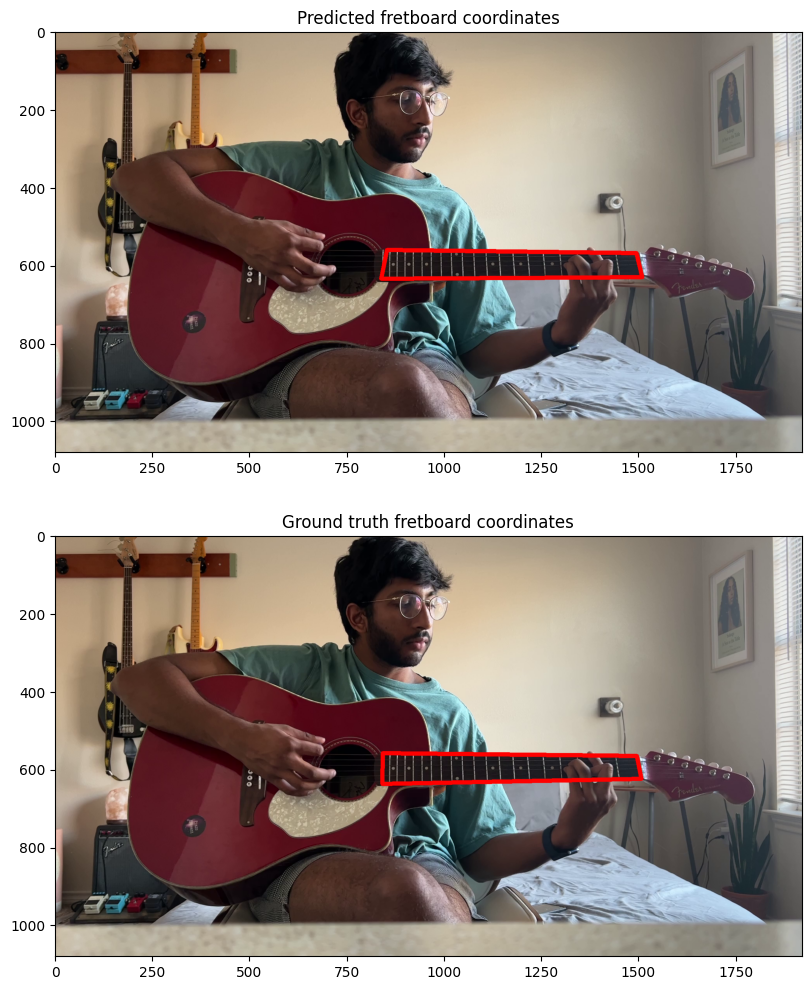

In [5]:
with torch.no_grad():
    file = test_fns[21]
    x = test[file]
    x = torch.Tensor(x)
    y = load_label(file, False)

    pred = net(x)
    test_loss = loss(pred, y)
    
    img = cv.imread(os.path.join(test_path, file))
    img2 = np.copy(img)
    pred_coords_vec = pred.detach().cpu().numpy()
    label_coords_vec = y.detach().cpu().numpy()
    
    unnormalize = np.array([1920, 1080])
    unnormalize = np.tile(unnormalize, 4)
    pred_coords_vec = pred_coords_vec * unnormalize
    label_coords_vec = label_coords_vec * unnormalize

    pred_coords = np.array([[pred_coords_vec[0], pred_coords_vec[1]], 
                            [pred_coords_vec[2], pred_coords_vec[3]],
                            [pred_coords_vec[4], pred_coords_vec[5]],
                            [pred_coords_vec[6], pred_coords_vec[7]]], np.int32)
    label_coords = np.array([[label_coords_vec[0], label_coords_vec[1]], 
                             [label_coords_vec[2], label_coords_vec[3]],
                             [label_coords_vec[4], label_coords_vec[5]],
                             [label_coords_vec[6], label_coords_vec[7]]], np.int32)
    
    pred_coords = pred_coords.reshape((-1,1,2))
    label_coords = label_coords.reshape((-1,1,2))
    
    cv.polylines(img, [pred_coords], True, (0,0,255), thickness=10)
    cv.polylines(img2, [label_coords], True, (0,0,255), thickness=10)

    plt.figure(figsize=(12,12))
    plt.subplot(2,1,1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title("Predicted fretboard coordinates")
    plt.subplot(2,1,2)
    plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
    plt.title("Ground truth fretboard coordinates")
    plt.show()